In [5]:
# import your code
from encoder import encode, header_bits
from decoder import decode
import numpy as np
import matplotlib.pyplot as plt

from cued_sf2_lab.familiarisation import load_mat_img, plot_image

from simple_lbt_functions import *

from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp


from scipy.optimize import minimize



Forward 8 x 8 DCT
Quantising to step size of 40
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 31423
Bits for huffman table = 1424
Bits: 31423
1424
Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 40.0
Inverse 8 x 8 DCT

0.0 256.0
RMS = 10.94438532128862


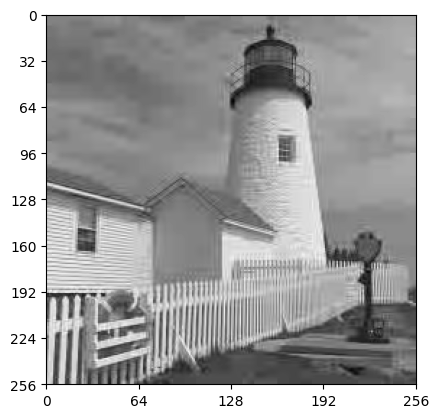

In [6]:
# Test encoder/decoder here
X, _ = load_mat_img('lighthouse.mat', img_info='X')
X = X - 128.0

#encode
step = 40
vlc, header = encode(X,jpeg_quant_size = step)
bits = vlc[:,1].sum()
print(f"Bits: {bits}")
print(header_bits(header))

#decode
Z = decode(vlc, header)
print(np.min(Z), np.max(Z)) # min max of Z
#print(Z[::64,::64].astype(int)) # typical numbers

fig, ax = plt.subplots()
plot_image(Z)

print(f"RMS = {np.std(X-Z)}")



In [7]:

def histogram_image(image):
    flattened_array = image.astype(int).flatten()
    hist, bins = np.histogram(flattened_array, bins=np.arange(min(flattened_array), max(flattened_array)+2))
    fig, ax = plt.subplots()
    ax.bar(bins[:-1], hist, align='center')
    xtick_positions = np.linspace(0, len(bins) - 2, num=6, dtype=int)
    xtick_labels = bins[:-1][xtick_positions]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)
    ax.set_ylabel('Frequency')
    ax.set_title('Number Frequency Histogram')
    plt.show()

#histogram_image(Z)

In [8]:
Y = lbt(X, N=8, s=1.31)
Z = ilbt(Y, N=8, s=1.31)
print(np.min(Y), np.max(Y))
print(Y[::32,::32].astype(int))

-972.8265057421221 944.8780953355696
[[ -73  -40  -73  -87  -30 -123    1  164]
 [-250 -247  -71  -64   36 -620  244  199]
 [  50   54 -201  -47 -207  640  240  243]
 [ 107 -108  -31  100 -184 -244  133  146]
 [ 288 -377 -190 -154 -311  593   52   93]
 [ 695  420  586  -63  800  662 -382 -564]
 [-209  300  320  464  435  337  317  148]
 [ 252  481  -85  196  194 -129 -131 -517]]


In [9]:
Y = lbt(X, N=8, s=1.31)


step = 17
print(f"Step = {step}")
for k in [0.5,1.0,1.5]:
    print(f"k = {k}")
    Yq = quantise(Y, step, step*k)
    print(f"Bits required: {bpp(Yq)*Yq.size}")

    Z = ilbt(Yq, N=8, s=1.31)
    #assert((X==Z).all())
    print(f"RMS: {np.std(X-Z)}")


Step = 17
k = 0.5
Bits required: 110195.68725701055
RMS: 3.5906176366288896
k = 1.0
Bits required: 77052.37736234156
RMS: 5.052939654353368
k = 1.5
Bits required: 58915.90726382516
RMS: 6.538217760970675


In [10]:
Y = lbt(X, N=8, s=1.31)

required_bits = 50000


def objective(step):
    Yq = quantise(Y, step, step*k)
    bits = bpp(Yq)*Yq.size
    if bits > required_bits:
        return np.abs(bits - required_bits) * 10 # Soft penalty, preserving the gradient
    else:
        return np.abs(bits - required_bits)


for k in [0.5,1.0,1.5]:
    print(f"k = {k}")

    result = minimize(objective, 40, method='Nelder-Mead')

    step_final = result.x[0]
    print(f"Step: {step_final}")

    Yq = quantise(Y, step_final, step_final*k)
    print(f"Bits: {bpp(Yq)*Yq.size}")

    Z = ilbt(Yq, N=8, s=1.31)
    #assert((X==Z).all())
    print(f"RMS: {np.std(X-Z)}")


k = 0.5
Step: 50.7216796875
Bits: 50000.25399639393
RMS: 7.790919392878196
k = 1.0
Step: 28.6915283203125
Bits: 49995.606574153324
RMS: 7.263923290830171
k = 1.5
Step: 20.431640625
Bits: 49995.10386554953
RMS: 7.398713142291664


In [11]:
Y = lbt(X, N=8, s=1.31)

required_bits = 50000

k_list = np.arange(0.5,3,0.1)
step_list = np.zeros_like(k_list)
rms_list = np.zeros_like(k_list)

def objective(step):
    Yq = quantise(Y, step, step*k)
    bits = bpp(Yq)*Yq.size
    if bits > required_bits:
        return np.abs(bits - required_bits) * 10 # Soft penalty, preserving the gradient
    else:
        return np.abs(bits - required_bits)


for i in range(len(k_list)):
    k = k_list[i] 

    result = minimize(objective, 40, method='Nelder-Mead')

    step_final = result.x[0]
    step_list[i] = step_final
    #print(f"Step: {step_final}")

    Yq = quantise(Y, step_final, step_final*k)
    #print(f"Bits: {bpp(Yq)*Yq.size}")

    Z = ilbt(Yq, N=8, s=1.31)
    #assert((X==Z).all())
    #print(f"RMS: {np.std(X-Z)}")
    rms_list[i] = np.std(X-Z)

Text(0, 0.5, 'RMS')

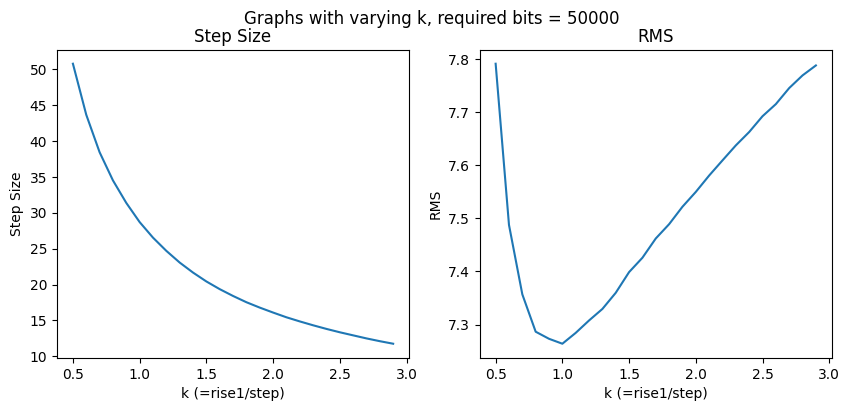

In [12]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

fig.suptitle(f"Graphs with varying k, required bits = {required_bits}")

axs[0].plot(k_list, step_list)
axs[0].set_title("Step Size")
axs[0].set_xlabel("k (=rise1/step)")
axs[0].set_ylabel("Step Size")

axs[1].plot(k_list, rms_list)
axs[1].set_title("RMS")
axs[1].set_xlabel("k (=rise1/step)")
axs[1].set_ylabel("RMS")